# GWExPy TimeSeries 相互運用性 (Interop) チュートリアル

このノートブックでは、`gwexpy` の `TimeSeries` クラスに追加された新しい相互運用機能 (Interoperability Features) を紹介します。
`gwexpy` は、Pandas, Xarray, PyTorch, Astropy などの一般的なデータサイエンス・ライブラリとの間で、シームレスにデータを変換することができます。

## 目次

- [1. 汎用データ形式・データ基盤](#1-汎用データ形式・データ基盤)
    - [1.1. NumPy [Original GWpy]](#11-numpy-original-gwpy)
    - [1.2. Pandas との連携 [Original GWpy]](#12-pandas-との連携-original-gwpy)
    - [1.3. Polars [GWExPy New]](#13-polars-gwexpy-new)
    - [1.4. Xarray との連携 [Original GWpy]](#14-xarray-との連携-original-gwpy)
    - [1.5. Dask との連携 [GWExPy New]](#15-dask-との連携-gwexpy-new)
    - [1.6. JSON / Python Dict (to_json) (to_json) [GWExPy New]](#16-json--python-dict-gwexpy-new)
- [2. データベース・ストレージ層](#2-データベース・ストレージ層)
    - [2.1. HDF5 [Original GWpy]](#21-hdf5-original-gwpy)
    - [2.2. SQLite [GWExPy New]](#22-sqlite-gwexpy-new)
    - [2.3. Zarr [GWExPy New]](#23-zarr-gwexpy-new)
    - [2.4. netCDF4 [GWExPy New]](#24-netcdf4-gwexpy-new)
- [3. 情報科学・機械学習・加速計算](#3-情報科学・機械学習・加速計算)
    - [3.1. PyTorch との連携 [GWExPy New]](#31-pytorch-との連携-gwexpy-new)
    - [3.2. CuPy (CUDA 加速) [GWExPy New]](#32-cupy-cuda-加速-gwexpy-new)
    - [3.3. TensorFlow との連携 [GWExPy New]](#33-tensorflow-との連携-gwexpy-new)
    - [3.4. JAX との連携 [GWExPy New]](#34-jax-との連携-gwexpy-new)
- [4. 天文学・重力波物理学](#4-天文学・重力波物理学)
    - [4.1. PyCBC / LAL [Original GWpy]](#41-pycbc--lal-original-gwpy)
    - [4.2. Astropy との連携 [Original GWpy]](#42-astropy-との連携-original-gwpy)
    - [4.3. Specutils との連携 [GWExPy New]](#43-specutils-との連携-gwexpy-new)
    - [4.4. Pyspeckit との連携 [GWExPy New]](#44-pyspeckit-との連携-gwexpy-new)
- [5. 素粒子物理学・高エネルギー物理](#5-素粒子物理学・高エネルギー物理)
    - [5.1. CERN ROOT との連携 [GWExPy New]](#51-cern-root-との連携-gwexpy-new)
    - [5.2. ROOT オブジェクトからの復元 (`from_root`)](#52-root-オブジェクトからの復元-`from_root`)
- [6. 地球物理学・地震学・電磁気学](#6-地球物理学・地震学・電磁気学)
    - [6.1. ObsPy [Original GWpy]](#61-obspy-original-gwpy)
    - [6.2. SimPEG との連携 [GWExPy New]](#62-simpeg-との連携-gwexpy-new)
    - [6.3. MTH5 / MTpy [GWExPy New]](#63-mth5--mtpy-gwexpy-new)
- [7. 音響・音声解析](#7-音響・音声解析)
    - [7.1. Librosa / Pydub [GWExPy New]](#71-librosa--pydub-gwexpy-new)
- [8. 医学・生体信号解析](#8-医学・生体信号解析)
    - [8.1. MNE-Python [GWExPy New]](#81-mne-python-gwexpy-new)
    - [8.2. Elephant / quantities との連携 [GWExPy New]](#82-elephant--quantities-との連携-gwexpy-new)
    - [8.3. Neo [GWExPy New]](#83-neo-gwexpy-new)
- [9. まとめ](#9-まとめ)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from gwpy.time import LIGOTimeGPS

from gwexpy.timeseries import TimeSeries

/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


Original TimeSeries:
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: demo_signal,
           channel: None)


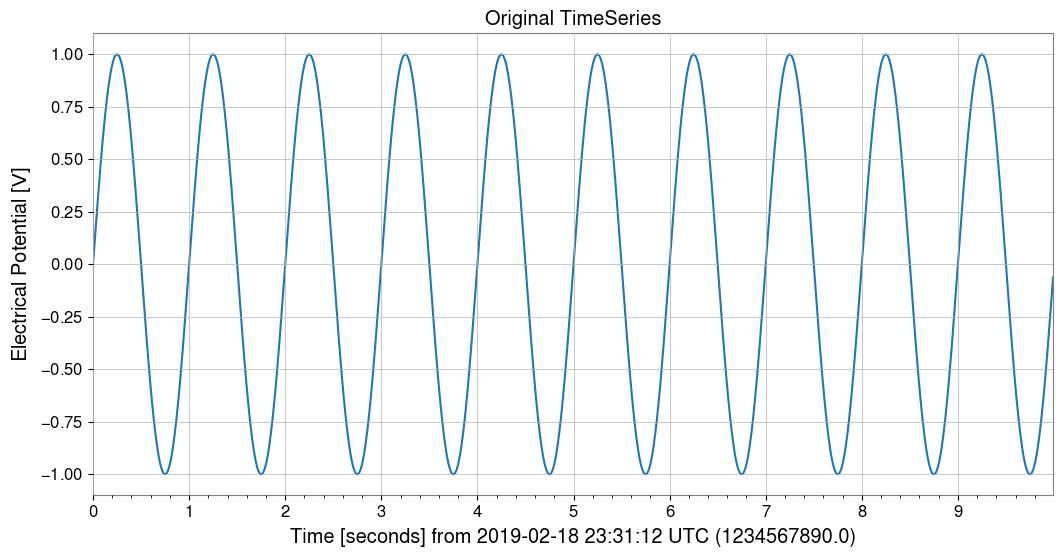

In [2]:
# サンプルデータの作成
# 10秒間、100Hzの正弦波データを生成します
rate = 100 * u.Hz
dt = 1 / rate
t0 = LIGOTimeGPS(1234567890, 0)
duration = 10 * u.s
size = int(rate * duration)
times = np.arange(size) * dt.value
data = np.sin(2 * np.pi * 1.0 * times)  # 1Hz sine wave

ts = TimeSeries(data, t0=t0, dt=dt, unit="V", name="demo_signal")
print("Original TimeSeries:")
print(ts)
ts.plot(title="Original TimeSeries");

## 1. 汎用データ形式・データ基盤


### 1.1. NumPy <span style="color: #3498db; font-weight: bold;">[Original GWpy]</span>

> **NumPy**: NumPy は Python の数値計算の基盤となるライブラリで、多次元配列と高速な数学演算を提供します。
> 📚 [NumPy Documentation](https://numpy.org/)

`TimeSeries.value` や `np.asarray(ts)` で NumPy 配列を取得できます。


### 1.2. Pandas との連携 <span style="color: #3498db; font-weight: bold;">[Original GWpy]</span>

> **Pandas**: Pandas はデータ分析・操作のための強力なライブラリで、DataFrame と Series による柔軟なデータ構造を提供します。
> 📚 [Pandas Documentation](https://pandas.pydata.org/)

`to_pandas()` メソッドを使うと、`TimeSeries` を `pandas.Series` に変換できます。
インデックスは `datetime` (UTC), `gps`, `seconds` (Unix timestamp) から選択可能です。



--- Converted to Pandas Series ---


time_utc
2019-02-18 23:31:49+00:00           0.000000
2019-02-18 23:31:49.010000+00:00    0.062791
2019-02-18 23:31:49.020000+00:00    0.125333
2019-02-18 23:31:49.030000+00:00    0.187381
2019-02-18 23:31:49.040000+00:00    0.248690
                                      ...   
2019-02-18 23:31:58.949991+00:00   -0.309017
2019-02-18 23:31:58.959991+00:00   -0.248690
2019-02-18 23:31:58.969990+00:00   -0.187381
2019-02-18 23:31:58.979990+00:00   -0.125333
2019-02-18 23:31:58.989990+00:00   -0.062791
Name: demo_signal, Length: 1000, dtype: float64

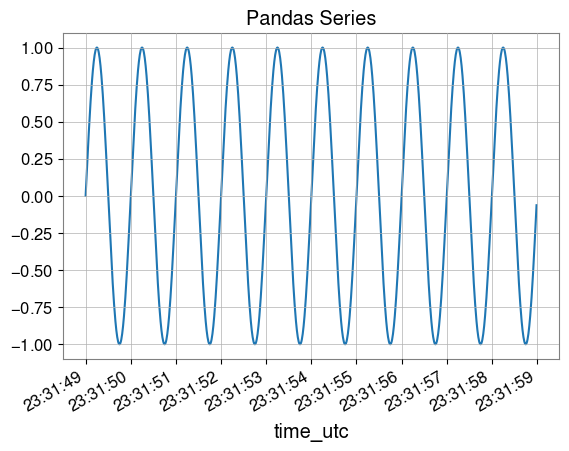


--- Restored TimeSeries from Pandas ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567927.0 s,
           dt: 0.009999990463256836 s,
           name: demo_signal,
           channel: None)


In [3]:
try:
    # Pandas Series への変換 (デフォルトは datetime index)
    s_pd = ts.to_pandas(index="datetime")
    print("\n--- Converted to Pandas Series ---")
    display(s_pd)
    s_pd.plot(title="Pandas Series")
    plt.show()
    plt.close()

    # Pandas Series から TimeSeries への復元
    ts_restored = TimeSeries.from_pandas(s_pd, unit="V")
    print("\n--- Restored TimeSeries from Pandas ---")
    print(ts_restored)

    del s_pd, ts_restored

except ImportError:
    print("Pandas is not installed.")

### 1.3. Polars <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **Polars**: Polars は Rust で実装された高速な DataFrame ライブラリで、大規模データの高速処理に優れています。
> 📚 [Polars Documentation](https://pola.rs/)

`to_polars()` で Polars DataFrame/Series に変換できます。


--- Polars DataFrame ---
shape: (5, 2)
┌────────────────────────────┬─────────────┐
│ time                       ┆ demo_signal │
│ ---                        ┆ ---         │
│ object                     ┆ f64         │
╞════════════════════════════╪═════════════╡
│ 2019-02-18 23:31:12        ┆ 0.0         │
│ 2019-02-18 23:31:12.010000 ┆ 0.062791    │
│ 2019-02-18 23:31:12.020000 ┆ 0.125333    │
│ 2019-02-18 23:31:12.030000 ┆ 0.187381    │
│ 2019-02-18 23:31:12.040000 ┆ 0.24869     │
└────────────────────────────┴─────────────┘


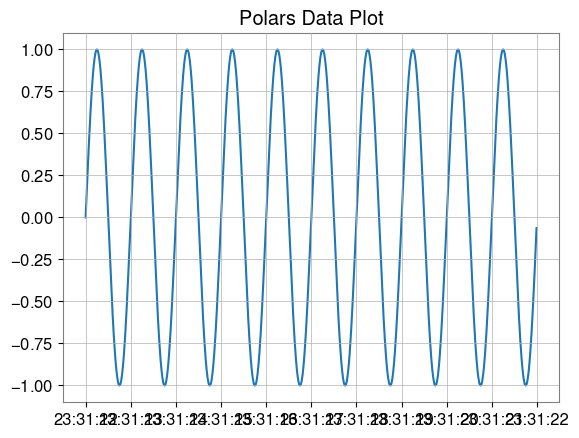

Recovered from Polars: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: dimensionless,
           t0: 1234567890.0 s,
           dt: None,
           name: demo_signal,
           channel: None)


In [4]:
try:
    import polars as pl

    # TimeSeries -> Polars DataFrame
    df_pl = ts.to_polars()
    print("--- Polars DataFrame ---")
    print(df_pl.head())

    # Plot using Polars/Matplotlib
    plt.figure()
    data_col = [c for c in df_pl.columns if c != "time"][0]
    plt.plot(df_pl["time"], df_pl[data_col])
    plt.title("Polars Data Plot")
    plt.show()

    # Recover to TimeSeries
    from gwexpy.timeseries import TimeSeries

    ts_recovered = TimeSeries.from_polars(df_pl)
    print("Recovered from Polars:", ts_recovered)

    del df_pl, ts_recovered

except ImportError:
    print("Polars not installed.")

### 1.4. Xarray との連携 <span style="color: #3498db; font-weight: bold;">[Original GWpy]</span>

> **xarray**: xarray は多次元ラベル付き配列のためのライブラリで、NetCDF データの操作や気象・地球科学データの解析に広く使用されます。
> 📚 [xarray Documentation](https://docs.xarray.dev/)

`xarray` は多次元のラベル付き配列を扱う強力なライブラリです。`to_xarray()` でメタデータを保持したまま変換できます。



--- Converted to Xarray DataArray ---
<xarray.DataArray 'demo_signal' (time: 1000)> Size: 8kB
array([ 0.        ,  0.06279052,  0.12533323, ..., -0.18738131,
       -0.12533323, -0.06279052], shape=(1000,))
Coordinates:
  * time     (time) datetime64[ns] 8kB 2019-02-18T23:31:49 ... 2019-02-18T23:...
Attributes:
    unit:        V
    name:        demo_signal
    channel:     None
    epoch:       1234567890.0
    time_coord:  datetime
Attributes: {'unit': 'V', 'name': 'demo_signal', 'channel': 'None', 'epoch': 1234567890.0, 'time_coord': 'datetime'}


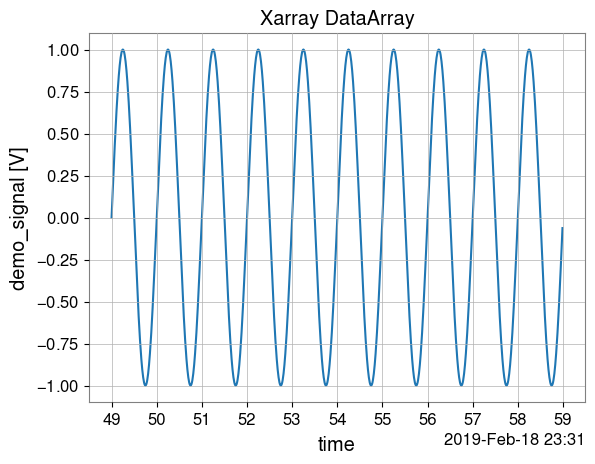


--- Restored TimeSeries from Xarray ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567927.0 s,
           dt: 0.009999990463256836 s,
           name: demo_signal,
           channel: None)


In [5]:
try:
    # Xarray DataArray への変換
    da = ts.to_xarray()
    print("\n--- Converted to Xarray DataArray ---")
    print(da)
    # メタデータ (attrs) が保持されているか確認
    print("Attributes:", da.attrs)

    da.plot()
    plt.title("Xarray DataArray")
    plt.show()
    plt.close()

    # 復元
    ts_x = TimeSeries.from_xarray(da)
    print("\n--- Restored TimeSeries from Xarray ---")
    print(ts_x)

    del da, ts_x

except ImportError:
    print("Xarray is not installed.")

### 1.5. Dask との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **Dask**: Dask は並列計算のためのライブラリで、NumPy/Pandas を超える大規模データの処理を可能にします。
> 📚 [Dask Documentation](https://www.dask.org/)


In [6]:
try:
    import dask.array as da

    # Dask Array への変換
    dask_arr = ts.to_dask(chunks="auto")
    print("\n--- Converted to Dask Array ---")
    print(dask_arr)

    # 戻す (compute=True で即座にロード)
    ts_from_dask = TimeSeries.from_dask(dask_arr, t0=ts.t0, dt=ts.dt, unit=ts.unit)
    print("Recovered from Dask:", ts_from_dask)

    del dask_arr, ts_from_dask

except ImportError:
    print("Dask not installed.")


--- Converted to Dask Array ---
dask.array<array, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>


Recovered from Dask: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


### 1.6. JSON / Python Dict (to_json) <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **JSON**: JSON (JavaScript Object Notation) は軽量なデータ交換フォーマットで、Python 標準ライブラリでサポートされています。
> 📚 [JSON Documentation](https://docs.python.org/3/library/json.html)

`to_json()` や `to_dict()` で JSON 互換の辞書形式を出力できます。


--- JSON Representation (Partial) ---
{
  "t0": 1234567890.0,
  "dt": 0.01,
  "unit": "V",
  "name": "demo_signal",
  "data": [
    0.0,
    0.06279051952931337,
    0.12533323356430426,
    0.1873813145857246,
    0.2486898871648548,
    0.3090169943749474,
    0.3681245526846779,
    0.4257792915650727,
    0.4817536741017153,
    0.5358267949789967,
    0.5877852522924731,
    0.6374239897486896,
    0.6845471059286886,
    0.7289686274214116,
    0.7705132427757893,
    0.8090169943749475,
    0.8443279255020151,
    0.876306680...


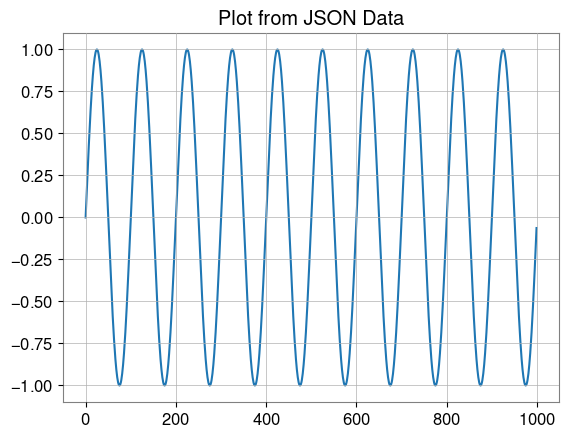

Recovered from JSON: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 s,
           dt: 0.01 s,
           name: demo_signal,
           channel: None)


In [7]:
import json

# TimeSeries -> JSON string
ts_json = ts.to_json()
print("--- JSON Representation (Partial) ---")
print(ts_json[:500] + "...")

# Plot data by loading back from JSON
ts_dict_temp = json.loads(ts_json)
plt.figure()
plt.plot(ts_dict_temp["data"])
plt.title("Plot from JSON Data")
plt.show()

# Recover from JSON
from gwexpy.timeseries import TimeSeries

ts_recovered = TimeSeries.from_json(ts_json)
print("Recovered from JSON:", ts_recovered)

del ts_json, ts_dict_temp, ts_recovered

## 2. データベース・ストレージ層


### 2.1. HDF5 <span style="color: #3498db; font-weight: bold;">[Original GWpy]</span>

> **HDF5**: HDF5 は大規模な科学データを効率的に保存・管理するための階層型データフォーマットです。h5py ライブラリで Python から利用できます。
> 📚 [HDF5 Documentation](https://www.h5py.org/)

`to_hdf5_dataset()` で HDF5 への保存をサポート。


--- HDF5 Dataset Info ---
Shape: (1000,), Dtype: float64
Attributes: {'dt': np.float64(0.01), 'name': 'demo_signal', 't0': np.float64(1234567890.0), 'unit': 'V'}
Recovered from HDF5: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 s,
           dt: 0.01 s,
           name: demo_signal,
           channel: None)


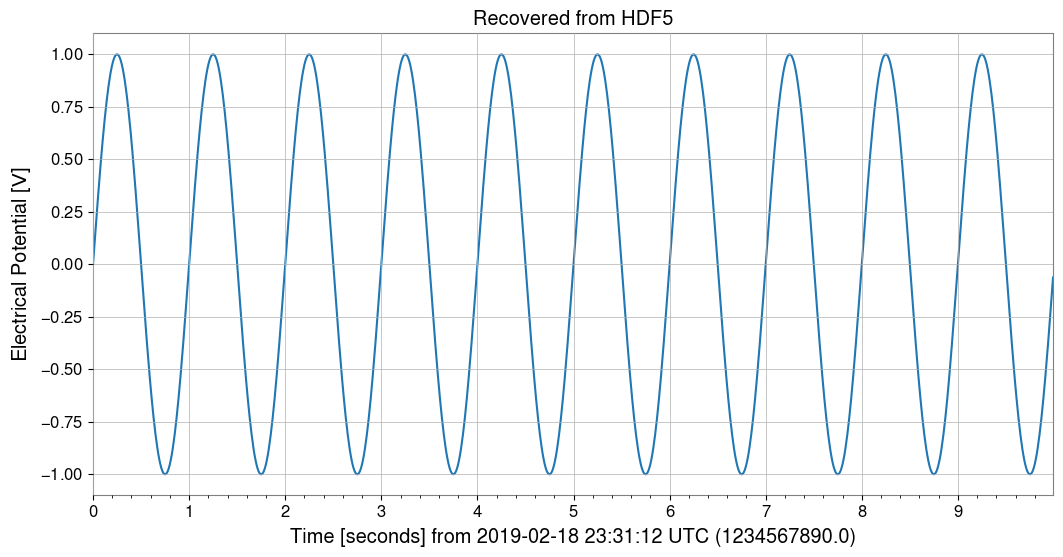

In [8]:
try:
    import tempfile

    import h5py

    with tempfile.NamedTemporaryFile(suffix=".h5") as tmp:
        # TimeSeries -> HDF5
        with h5py.File(tmp.name, "w") as f:
            ts.to_hdf5_dataset(f, "dataset_01")

        # Read back and display
        with h5py.File(tmp.name, "r") as f:
            ds = f["dataset_01"]
            print("--- HDF5 Dataset Info ---")
            print(f"Shape: {ds.shape}, Dtype: {ds.dtype}")
            print("Attributes:", dict(ds.attrs))

            # Recover
            from gwexpy.timeseries import TimeSeries

            ts_recovered = TimeSeries.from_hdf5_dataset(f, "dataset_01")
            print("Recovered from HDF5:", ts_recovered)

            ts_recovered.plot()
            plt.title("Recovered from HDF5")
            plt.show()

            del ds, ts_recovered

except ImportError:
    print("h5py not installed.")

### 2.2. SQLite <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **SQLite**: SQLite は軽量な組み込み型 SQL データベースエンジンで、Python 標準ライブラリに含まれています。
> 📚 [SQLite Documentation](https://docs.python.org/3/library/sqlite3.html)

`to_sqlite()` で DB 永続化をサポート。


Saved to SQLite with ID: test_series
Metadata from SQL: ('test_series', '', 'V', 1234567890.0, 0.01, 1000, '{"name": "demo_signal"}')
Recovered from SQLite: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 s,
           dt: 0.01 s,
           name: test_series,
           channel: None)


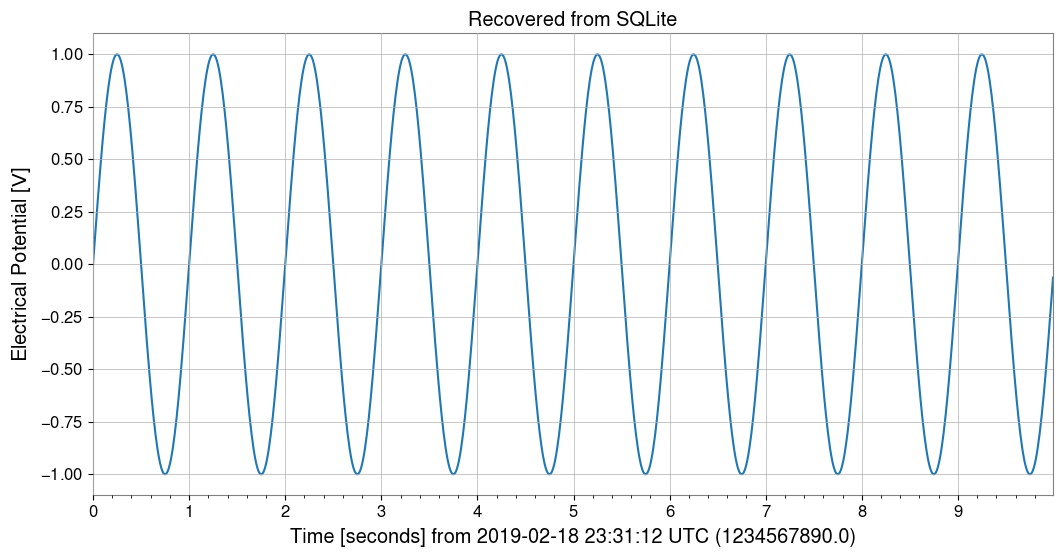

In [9]:
import sqlite3

conn = sqlite3.connect(":memory:")

# TimeSeries -> SQLite
series_id = ts.to_sqlite(conn, series_id="test_series")
print(f"Saved to SQLite with ID: {series_id}")

# Verify data in SQL
cursor = conn.cursor()
row = cursor.execute("SELECT * FROM series WHERE series_id=?", (series_id,)).fetchone()
print("Metadata from SQL:", row)

# Recover
from gwexpy.timeseries import TimeSeries

ts_recovered = TimeSeries.from_sqlite(conn, series_id)
print("Recovered from SQLite:", ts_recovered)

ts_recovered.plot()
plt.title("Recovered from SQLite")
plt.show()

del series_id, conn, cursor, ts_recovered

### 2.3. Zarr <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **Zarr**: Zarr はチャンク化・圧縮された多次元配列のためのストレージフォーマットで、クラウドストレージとの連携に優れています。
> 📚 [Zarr Documentation](https://zarr.dev/)

`to_zarr()` でクラウドストレージ向き形式に対応。


--- Zarr Array Info ---
Type               : Array
Zarr format        : 3
Data type          : Float64(endianness='little')
Fill value         : 0.0
Shape              : (1000,)
Chunk shape        : (1000,)
Order              : C
Read-only          : True
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 8000 (7.8K)
Recovered from Zarr: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 s,
           dt: 0.01 s,
           name: demo_signal,
           channel: None)


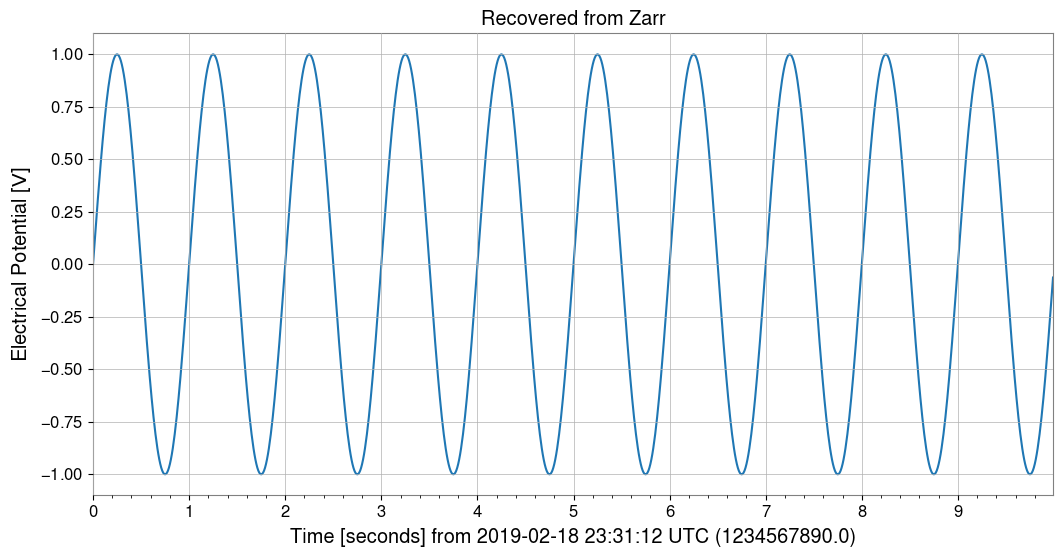

In [10]:
try:
    import os
    import tempfile

    import zarr

    with tempfile.TemporaryDirectory() as tmpdir:
        store_path = os.path.join(tmpdir, "test.zarr")
        # TimeSeries -> Zarr
        ts.to_zarr(store_path, path="timeseries")

        # Read back
        z = zarr.open(store_path, mode="r")
        ds = z["timeseries"]
        print("--- Zarr Array Info ---")
        print(ds.info)

        # Recover
        from gwexpy.timeseries import TimeSeries

        ts_recovered = TimeSeries.from_zarr(store_path, "timeseries")
        print("Recovered from Zarr:", ts_recovered)

        ts_recovered.plot()
        plt.title("Recovered from Zarr")
        plt.show()

        del z, ds, ts_recovered

except ImportError:
    print("zarr not installed.")

### 2.4. netCDF4 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **netCDF4**: netCDF4 は気象・海洋・地球科学データの標準フォーマットで、自己記述的なデータ構造を持ちます。
> 📚 [netCDF4 Documentation](https://unidata.github.io/netcdf4-python/)

`to_netcdf4()` で気象・海洋データの標準に対応。


In [11]:
try:
    import tempfile

    import netCDF4

    with tempfile.NamedTemporaryFile(suffix=".nc") as tmp:
        # TimeSeries -> netCDF4
        with netCDF4.Dataset(tmp.name, "w") as ds:
            ts.to_netcdf4(ds, "my_signal")

        # Read back
        with netCDF4.Dataset(tmp.name, "r") as ds:
            v = ds.variables["my_signal"]
            print("--- netCDF4 Variable Info ---")
            print(v)

            # Recover
            from gwexpy.timeseries import TimeSeries

            ts_recovered = TimeSeries.from_netcdf4(ds, "my_signal")
            print("Recovered from netCDF4:", ts_recovered)

            ts_recovered.plot()
            plt.title("Recovered from netCDF4")
            plt.show()

            del v, ts_recovered

except ImportError:
    print("netCDF4 not installed.")

netCDF4 not installed.


## 3. 情報科学・機械学習・加速計算


### 3.1. PyTorch との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **PyTorch**: PyTorch は深層学習フレームワークで、動的計算グラフと GPU 加速をサポートします。
> 📚 [PyTorch Documentation](https://pytorch.org/)

ディープラーニングの前処理として、`TimeSeries` を直接 `torch.Tensor` に変換できます。GPU転送も可能です。


In [12]:
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")
import os

try:
    import torch

    # PyTorch Tensor への変換
    tensor = ts.to_torch(dtype=torch.float32)
    print("\n--- Converted to PyTorch Tensor ---")
    print(f"Tensor shape: {tensor.shape}, dtype: {tensor.dtype}")

    # Tensor からの復元 (t0, dt は別途指定が必要)
    ts_torch = TimeSeries.from_torch(tensor, t0=ts.t0, dt=ts.dt, unit="V")
    print("\n--- Restored from Torch ---")
    print(ts_torch)

    del tensor, ts_torch

except ImportError:
    print("PyTorch is not installed.")


--- Converted to PyTorch Tensor ---
Tensor shape: torch.Size([1000]), dtype: torch.float32

--- Restored from Torch ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


### 3.2. CuPy (CUDA 加速) <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **CuPy**: CuPy は NumPy 互換の GPU 配列ライブラリで、NVIDIA CUDA を使用した高速計算を可能にします。
> 📚 [CuPy Documentation](https://cupy.dev/)

GPU 上での計算を可能にする CuPy 配列へ変換できます。


In [13]:
from gwexpy.interop import is_cupy_available

if is_cupy_available():
    import cupy as cp

    # TimeSeries -> CuPy
    y_gpu = ts.to_cupy()
    print("--- CuPy Array (on GPU) ---")
    print(y_gpu)

    # Simple processing on GPU
    y_gpu_filt = y_gpu * 2.0

    # Plot (must move to CPU for plotting)
    plt.figure()
    plt.plot(cp.asnumpy(y_gpu_filt))
    plt.title("CuPy Data (Moved to CPU for plot)")
    plt.show()

    # Recover
    from gwexpy.timeseries import TimeSeries

    ts_recovered = TimeSeries.from_cupy(y_gpu_filt, t0=ts.t0, dt=ts.dt)
    print("Recovered from CuPy:", ts_recovered)

    del y_gpu, y_gpu_filt, ts_recovered

else:
    print("CuPy or CUDA driver not available.")

CuPy or CUDA driver not available.


### 3.3. TensorFlow との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **TensorFlow**: TensorFlow は Google が開発した機械学習プラットフォームで、大規模な本番環境での利用に優れています。
> 📚 [TensorFlow Documentation](https://www.tensorflow.org/)


In [14]:
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
try:
    import tensorflow as tf

    # TensorFlow Tensor への変換
    tf_tensor = ts.to_tensorflow()
    print("\n--- Converted to TensorFlow Tensor ---")
    print(f"Tensor shape: {tf_tensor.shape}")
    print(f"Tensor dtype: {tf_tensor.dtype}")

    # 戻す
    ts_from_tensorflow = TimeSeries.from_tensorflow(
        tf_tensor, t0=ts.t0, dt=ts.dt, unit=ts.unit
    )
    print("Recovered from TF:", ts_from_tensorflow)

    del tf_tensor, ts_from_tensorflow

except ImportError:
    print("TensorFlow not installed.")

2026-01-21 17:19:25.258393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 17:19:25.305088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility 


--- Converted to TensorFlow Tensor ---
Tensor shape: (1000,)
Tensor dtype: <dtype: 'float64'>
Recovered from TF: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


I0000 00:00:1768983567.057456 2253350 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6189 MB memory:  -> device: 0, name: NVIDIA RTX A1000, pci bus id: 0000:55:00.0, compute capability: 8.6
I0000 00:00:1768983567.057954 2253350 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 2317 MB memory:  -> device: 1, name: Quadro P2000, pci bus id: 0000:a2:00.0, compute capability: 6.1


### 3.4. JAX との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **JAX**: JAX は Google が開発した高性能数値計算ライブラリで、自動微分と XLA コンパイルによる高速化が特徴です。
> 📚 [JAX Documentation](https://jax.readthedocs.io/)


In [15]:
try:
    import os

    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
    import jax
    import jax.numpy as jnp

    # JAX Array への変換
    jax_arr = ts.to_jax()
    print("\n--- Converted to JAX Array ---")
    print(f"Array shape: {jax_arr.shape}")

    # 戻す
    ts_from_jax = TimeSeries.from_jax(jax_arr, t0=ts.t0, dt=ts.dt, unit=ts.unit)
    print("Recovered from JAX:", ts_from_jax)

    del jax_arr, ts_from_jax
except ImportError:
    print("JAX not installed.")


--- Converted to JAX Array ---
Array shape: (1000,)
Recovered from JAX: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


## 4. 天文学・重力波物理学


### 4.1. PyCBC / LAL <span style="color: #3498db; font-weight: bold;">[Original GWpy]</span>

> **LAL**: LAL (LIGO Algorithm Library) は LIGO/Virgo の公式解析ライブラリで、重力波解析の基盤を提供します。
> 📚 [LAL Documentation](https://lscsoft.docs.ligo.org/lalsuite/)

> **PyCBC**: PyCBC は重力波データ解析のためのライブラリで、信号探索やパラメータ推定に使用されます。
> 📚 [PyCBC Documentation](https://pycbc.org/)

重力波解析の標準ツールとの互換性を備えています。


### 4.2. Astropy との連携 <span style="color: #3498db; font-weight: bold;">[Original GWpy]</span>

> **Astropy**: Astropy は天文学のための Python ライブラリで、座標変換、時間系変換、単位系などをサポートします。
> 📚 [Astropy Documentation](https://www.astropy.org/)

天文学分野で標準的な `astropy.timeseries.TimeSeries` との相互変換もサポートしています。



--- Converted to Astropy TimeSeries ---
     time            value       
------------- -------------------
 1234567890.0                 0.0
1234567890.01 0.06279051952931337
1234567890.02 0.12533323356430426
1234567890.03  0.1873813145857246
1234567890.04  0.2486898871648548


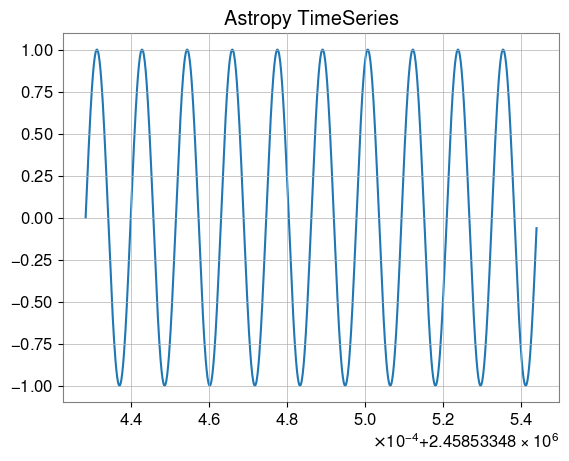


--- Restored from Astropy ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: dimensionless,
           t0: 1234567890.0 s,
           dt: 0.009999990463256836 s,
           name: None,
           channel: None)


In [16]:
try:
    # Astropy TimeSeries への変換
    ap_ts = ts.to_astropy_timeseries()
    print("\n--- Converted to Astropy TimeSeries ---")
    print(ap_ts[:5])
    fig, ax = plt.subplots()
    ax.plot(ap_ts.time.jd, ap_ts["value"])
    plt.title("Astropy TimeSeries")
    plt.show()
    plt.close()

    # 復元
    ts_astro = TimeSeries.from_astropy_timeseries(ap_ts)
    print("\n--- Restored from Astropy ---")
    print(ts_astro)

    del ap_ts, ts_astro

except ImportError:
    print("Astropy is not installed.")

### 4.3. Specutils との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **specutils**: specutils は天文スペクトルデータの操作・解析のための Astropy 関連パッケージです。
> 📚 [specutils Documentation](https://specutils.readthedocs.io/)

`FrequencySeries` は、Astropy エコシステムのスペクトル解析ライブラリ `specutils` の `Spectrum1D` オブジェクトと相互変換可能です。
単位 (Units) や周波数軸が適切に保持されます。


In [17]:
try:
    import specutils
    from astropy import units as u

    from gwexpy.frequencyseries import FrequencySeries

    # FrequencySeries -> specutils.Spectrum1D
    fs = FrequencySeries(
        np.random.random(100), frequencies=np.linspace(10, 100, 100), unit="Jy"
    )
    spec = fs.to_specutils()
    print("specutils Spectrum1D:", spec)
    print("Spectral axis unit:", spec.spectral_axis.unit)

    # specutils.Spectrum1D -> FrequencySeries
    fs_rec = FrequencySeries.from_specutils(spec)
    print("Restored FrequencySeries unit:", fs_rec.unit)

    del fs, spec, fs_rec

except ImportError:
    print("specutils library not found. Skipping example.")

specutils Spectrum1D: Spectrum (length=100)
Flux=[0.42879506 0.07025396 0.02352452 ... 0.69574823 0.04804405
      0.94679407] Jy,  mean=0.51280 Jy
Spectral Axis=[ 10.          10.90909091  11.81818182 ...
                98.18181818  99.09090909 100.        ] Hz,  mean=55.00000 Hz
Spectral axis unit: Hz
Restored FrequencySeries unit: Jy


### 4.4. Pyspeckit との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **PySpecKit**: PySpecKit は電波天文学のスペクトル解析ツールキットで、スペクトル線のフィッティングなどをサポートします。
> 📚 [PySpecKit Documentation](https://pyspeckit.readthedocs.io/)

`FrequencySeries` は、汎用的なスペクトル解析ツールキット `pyspeckit` の `Spectrum` オブジェクトとも連携可能です。


In [18]:
try:
    import pyspeckit

    from gwexpy.frequencyseries import FrequencySeries

    # FrequencySeries -> pyspeckit.Spectrum
    fs = FrequencySeries(np.random.random(100), frequencies=np.linspace(10, 100, 100))
    spec = fs.to_pyspeckit()
    print("pyspeckit Spectrum length:", len(spec.data))

    # pyspeckit.Spectrum -> FrequencySeries
    fs_rec = FrequencySeries.from_pyspeckit(spec)
    print("Restored FrequencySeries length:", len(fs_rec))

    del fs, spec, fs_rec

except ImportError:
    print("pyspeckit library not found. Skipping example.")

pyspeckit library not found. Skipping example.


## 5. 素粒子物理学・高エネルギー物理


### 5.1. CERN ROOT との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **ROOT**: ROOT は CERN が開発した高エネルギー物理学向けのデータ解析フレームワークです。
> 📚 [ROOT Documentation](https://root.cern/)

高エネルギー物理学で標準的なツールである **ROOT** との相互運用が強化されました。
`gwexpy` の Series オブジェクトを ROOT の `TGraph` や `TH1D`, `TH2D` に高速に変換したり、ROOT ファイルを作成することができます。
逆に、ROOT オブジェクトから `TimeSeries` などを復元することも可能です。

**Note**: この機能を使用するには `ROOT` (PyROOT) がインストールされている必要があります。


In [19]:
try:
    import numpy as np
    import ROOT

    from gwexpy.interop.root_ import from_root, to_tgraph, to_th1d
    from gwexpy.spectrogram import Spectrogram
    from gwexpy.timeseries import TimeSeries

    # データの準備
    t = np.linspace(0, 10, 1000)
    data = np.sin(2 * np.pi * 1.0 * t) + np.random.normal(0, 0.5, size=len(t))
    ts = TimeSeries(data, dt=t[1] - t[0], name="signal")

    # --- 1. TGraph への変換 ---
    # ベクトル化された高速な変換
    graph = ts.to_tgraph()

    # ROOT キャンバスでのプロット
    c1 = ROOT.TCanvas("c1", "TGraph Example", 800, 600)
    graph.SetTitle("ROOT TGraph;GPS Time [s];Amplitude")
    graph.Draw("AL")
    c1.Draw()
    # c1.SaveAs("signal_graph.png") # 画像として保存する場合

    print(f"Created TGraph: {graph.GetName()} with {graph.GetN()} points")

    # --- 2. TH1D (ヒストグラム) への変換 ---
    # ヒストグラムとして変換 (ビン詰めは自動または指定可能)
    hist = ts.to_th1d()

    c2 = ROOT.TCanvas("c2", "TH1D Example", 800, 600)
    hist.SetTitle("ROOT TH1D;GPS Time [s];Amplitude")
    hist.SetLineColor(ROOT.kRed)
    hist.Draw()
    c2.Draw()

    print(f"Created TH1D: {hist.GetName()} with {hist.GetNbinsX()} bins")

    del t, data, graph, hist, c1, c2

except ImportError:
    print("ROOT is not installed. Skipping ROOT examples.")
except Exception as e:
    print(f"An error occurred: {e}")

Created TGraph: signal with 1000 points
Created TH1D: signal with 1000 bins


### 5.2. ROOT オブジェクトからの復元 (`from_root`)

> **ROOT**: ROOT は CERN が開発した高エネルギー物理学向けのデータ解析フレームワークです。
> 📚 [ROOT Documentation](https://root.cern/)

既存の ROOT ファイルにあるヒストグラムやグラフを読み込んで、解析しやすい `gwexpy` オブジェクトに戻すことができます。


In [20]:
try:
    if "hist" in locals() and hist:
        # ROOT TH1D -> TimeSeries
        # ヒストグラムのビン内容を時系列データとして読み込みます
        ts_restored = from_root(TimeSeries, hist)

        print(f"Restored TimeSeries: {ts_restored.name}")
        print(ts_restored)

        # TGraph からの復元も同様
        ts_from_graph = from_root(TimeSeries, graph)
        print(f"Restored from TGraph: {len(ts_from_graph)} samples")

        del ts_restored, ts_from_graph

except NameError:
    pass  # hist や graph が作成されなかった場合
except ImportError:
    pass

## 6. 地球物理学・地震学・電磁気学


### 6.1. ObsPy <span style="color: #3498db; font-weight: bold;">[Original GWpy]</span>

> **ObsPy**: ObsPy は地震学データの取得・処理・解析のための Python ライブラリで、MiniSEED 形式などをサポートします。
> 📚 [ObsPy Documentation](https://docs.obspy.org/)

地震学で標準的な ObsPy との相互運用をサポート。


--- ObsPy Trace ---
.signal.. | 1980-01-06T00:00:00.000000Z - 1980-01-06T00:00:10.000000Z | 99.9 Hz, 1000 samples


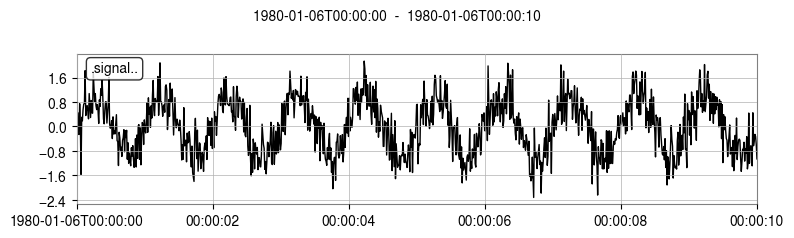

Recovered from ObsPy: TimeSeries([-0.53496635,  0.45788303, -0.22167066, ...,
            -0.32661698, -0.5842174 , -1.05965582]
           unit: dimensionless,
           t0: 0.0 s,
           dt: 0.01001001001001001 s,
           name: .signal..,
           channel: None)


In [21]:
try:
    import obspy

    # TimeSeries -> ObsPy Trace
    tr = ts.to_obspy()
    print("--- ObsPy Trace ---")
    print(tr)

    # Plot using ObsPy
    tr.plot()

    # Recover to TimeSeries
    from gwexpy.timeseries import TimeSeries

    ts_recovered = TimeSeries.from_obspy(tr)
    print("Recovered from ObsPy:", ts_recovered)

    del tr, ts_recovered

except ImportError:
    print("ObsPy not installed.")

In [22]:
try:
    import obspy

    tr = ts.to_obspy()
    print("ObsPy Trace:", tr)

    del tr

except ImportError:
    print("ObsPy not installed.")

ObsPy Trace: .signal.. | 1980-01-06T00:00:00.000000Z - 1980-01-06T00:00:10.000000Z | 99.9 Hz, 1000 samples


### 6.2. SimPEG との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **SimPEG**: SimPEG は地球物理学的逆問題のシミュレーション・推定フレームワークです。
> 📚 [SimPEG Documentation](https://simpeg.xyz/)

`gwexpy` は、地球物理学のフォワード計算・反転モデリングライブラリである `SimPEG` との連携をサポートしています。
`TimeSeries` (TDEM) および `FrequencySeries` (FDEM) を `simpeg.data.Data` オブジェクトに変換したり、その逆を行ったりできます。


In [23]:
try:
    import numpy as np
    import simpeg
    from simpeg import maps

    from gwexpy.frequencyseries import FrequencySeries
    from gwexpy.timeseries import TimeSeries

    # --- TimeSeries -> SimPEG (TDEM想定) ---
    ts = TimeSeries(np.random.normal(size=100), dt=0.01, unit="A/m^2")
    simpeg_data_td = ts.to_simpeg(location=np.array([0, 0, 0]))
    print("SimPEG TDEM data shape:", simpeg_data_td.dobs.shape)

    # --- FrequencySeries -> SimPEG (FDEM想定) ---
    fs = FrequencySeries(
        np.random.normal(size=10) + 1j * 0.1, frequencies=np.logspace(0, 3, 10)
    )
    simpeg_data_fd = fs.to_simpeg(location=np.array([0, 0, 0]), orientation="z")
    print("SimPEG FDEM data shape:", simpeg_data_fd.dobs.shape)

    del simpeg_data_td, simpeg_data_fd, fs

except ImportError:
    print("SimPEG library not found. Skipping example.")

SimPEG library not found. Skipping example.


### 6.3. MTH5 / MTpy <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **MTH5**: MTH5 は磁気地電流 (MT) データのための HDF5 ベースのデータフォーマットです。
> 📚 [MTH5 Documentation](https://mth5.readthedocs.io/)

地磁気地電流法データの MTH5 保存に対応。


2026-01-21T17:19:29.766075+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterSurvey, skipping from_dict.


2026-01-21T17:19:29.767600+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for Reports, skipping from_dict.


2026-01-21T17:19:30.039378+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for Standards, skipping from_dict.


2026-01-21T17:19:30.045039+0900 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file /tmp/tmp0v2y4cnp.h5 in mode a


2026-01-21T17:19:30.048629+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterStation, skipping from_dict.


2026-01-21T17:19:30.049313+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for Reports, skipping from_dict.


2026-01-21T17:19:30.050116+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for Filters, skipping from_dict.


2026-01-21T17:19:30.304465+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for Standards, skipping from_dict.


2026-01-21T17:19:30.310262+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for Station, skipping from_dict.


2026-01-21T17:19:30.313568+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for TransferFunctions, skipping from_dict.


2026-01-21T17:19:30.314216+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterFC, skipping from_dict.


2026-01-21T17:19:30.314701+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterFeatures, skipping from_dict.


2026-01-21T17:19:30.315788+0900 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2026-01-21T17:19:30.325249+0900 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /tmp/tmp0v2y4cnp.h5


Saved to MTH5 file: /tmp/tmp0v2y4cnp.h5
2026-01-21T17:19:30.336563+0900 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /tmp/tmp0v2y4cnp.h5


Recovered from MTH5: TimeSeries([-0.53496635,  0.45788303, -0.22167066, ...,
            -0.32661698, -0.5842174 , -1.05965582]
           unit: dimensionless,
           t0: 0.0 s,
           dt: 1.0 s,
           name: signal,
           channel: None)


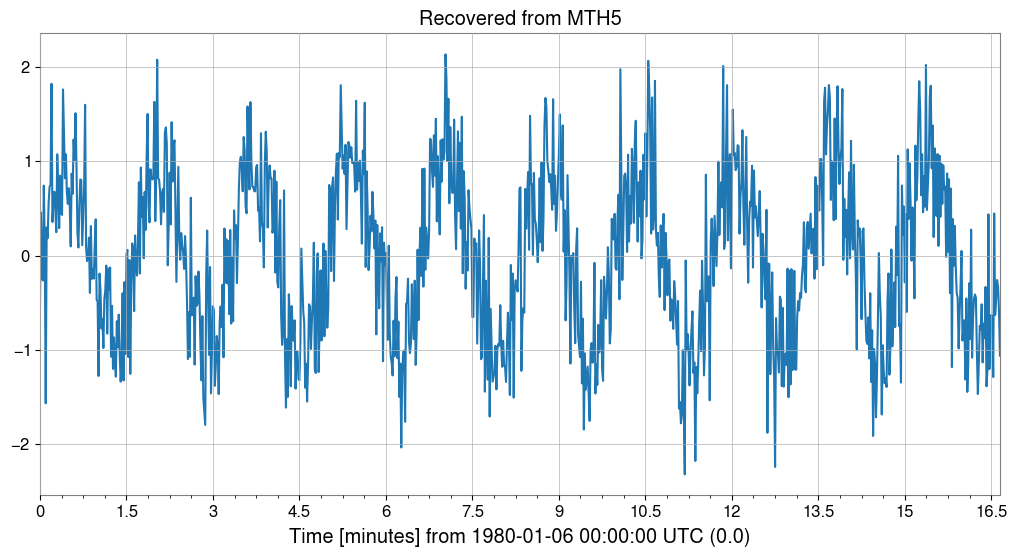

In [24]:
try:
    import tempfile

    import mth5

    with tempfile.NamedTemporaryFile(suffix=".h5") as tmp:
        from gwexpy.interop.mt_ import from_mth5, to_mth5

        # TimeSeries -> MTH5
        # We need to provide station and run names for MTH5 structure
        to_mth5(ts, tmp.name, station="SITE01", run="RUN01")
        print(f"Saved to MTH5 file: {tmp.name}")

        # Display structure info if needed, or just recover
        # Recover
        ts_recovered = from_mth5(tmp.name, "SITE01", "RUN01", ts.name or "Ex")
        print("Recovered from MTH5:", ts_recovered)

        ts_recovered.plot()
        plt.title("Recovered from MTH5")
        plt.show()

        del ts_recovered

except ImportError:
    print("mth5 not installed.")

## 7. 音響・音声解析


### 7.1. Librosa / Pydub <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **pydub**: pydub はオーディオファイルの操作（編集・変換・エフェクト）のためのシンプルなライブラリです。
> 📚 [pydub Documentation](https://github.com/jiaaro/pydub)

> **librosa**: librosa は音声・音楽解析のためのライブラリで、スペクトル解析やビート検出などの機能を提供します。
> 📚 [librosa Documentation](https://librosa.org/)

音声処理ライブラリ Librosa や Pydub との連携をサポート。


--- Librosa Data ---
Signal shape: (1000,), Sample rate: 99


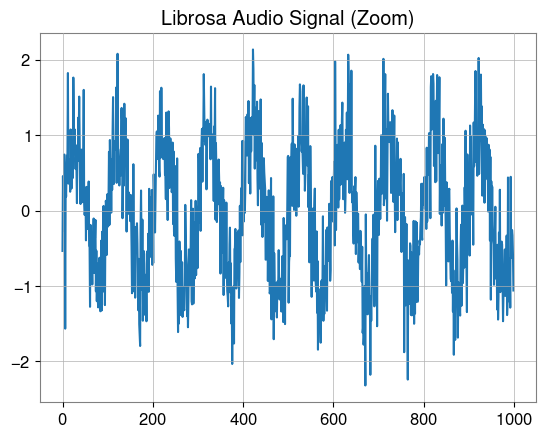

Recovered from Librosa: TimeSeries([-0.53496635,  0.45788303, -0.22167066, ...,
            -0.32661697, -0.58421737, -1.0596558 ]
           unit: dimensionless,
           t0: 0.0 s,
           dt: 0.010101010101010102 s,
           name: None,
           channel: None)


In [25]:
try:
    import librosa
    import matplotlib.pyplot as plt

    # TimeSeries -> Librosa (y, sr)
    y, sr = ts.to_librosa()
    print(f"--- Librosa Data ---\nSignal shape: {y.shape}, Sample rate: {sr}")

    # Plot using librosa style (matplotlib)
    plt.figure()
    plt.plot(y[:1000])  # Plot first 1000 samples
    plt.title("Librosa Audio Signal (Zoom)")
    plt.show()

    # Recover to TimeSeries
    from gwexpy.timeseries import TimeSeries

    ts_recovered = TimeSeries(y, dt=1.0 / sr)
    print("Recovered from Librosa:", ts_recovered)

    del y, sr
except ImportError:
    print("Librosa not installed.")

## 8. 医学・生体信号解析


### 8.1. MNE-Python <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **MNE**: MNE-Python は脳波 (EEG)・脳磁図 (MEG) データの解析ライブラリで、神経科学研究に広く使用されています。
> 📚 [MNE Documentation](https://mne.tools/)

脳電図 (EEG/MEG) 解析パッケージ MNE との連携。


In [26]:
try:
    import mne

    # TimeSeries -> MNE Raw
    raw = ts.to_mne()
    print("--- MNE Raw ---")
    print(raw)

    # Display info
    print(raw.info)

    # Recover to TimeSeries
    from gwexpy.timeseries import TimeSeries

    ts_recovered = TimeSeries.from_mne(raw, channel=ts.name or "ch0")
    print("Recovered from MNE:", ts_recovered)

    del raw, ts_recovered

except ImportError:
    print("MNE not installed.")

Creating RawArray with float64 data, n_channels=1, n_times=1000


    Range : 0 ... 999 =      0.000 ...    10.000 secs


Ready.


--- MNE Raw ---
<RawArray | 1 x 1000 (10.0 s), ~13 KiB, data loaded>


<Info | 7 non-empty values
 bads: []
 ch_names: signal
 chs: 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 99.9 Hz
>


Recovered from MNE: TimeSeries([-0.53496635,  0.45788303, -0.22167066, ...,
            -0.32661698, -0.5842174 , -1.05965582]
           unit: dimensionless,
           t0: 0.0 s,
           dt: 0.01001001001001001 s,
           name: signal,
           channel: None)


In [27]:
try:
    import mne

    raw = ts.to_mne()
    print("MNE Raw:", raw)

    del raw
except ImportError:
    print("MNE not installed.")

Creating RawArray with float64 data, n_channels=1, n_times=1000


    Range : 0 ... 999 =      0.000 ...    10.000 secs


Ready.


MNE Raw: <RawArray | 1 x 1000 (10.0 s), ~13 KiB, data loaded>


### 8.2. Elephant / quantities との連携 <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

`gwexpy` の `FrequencySeries` や `Spectrogram` は、`quantities.Quantity` オブジェクトと相互変換可能です。
これは Elephant や Neo との連携に役立ちます。

※ 事前に `pip install quantities` が必要です。


In [28]:
try:
    import numpy as np
    import quantities as pq

    from gwexpy.frequencyseries import FrequencySeries

    # FrequencySeries の作成
    freqs = np.linspace(0, 100, 101)
    data_fs = np.random.random(101)
    fs = FrequencySeries(data_fs, frequencies=freqs, unit="V")

    # to_quantities
    q_obj = fs.to_quantities(units="mV")
    print("Quantities object:", q_obj)

    # from_quantities
    fs_new = FrequencySeries.from_quantities(q_obj, frequencies=freqs)
    print("Restored FrequencySeries unit:", fs_new.unit)

    del freqs, data_fs, fs, q_obj, fs_new

except ImportError:
    print("quantities library not found. Skipping example.")

Quantities object: [104.66031297 904.01287175 985.57805002 520.51720764
 527.06702056 349.66013446 523.91310661 626.94796244
 698.56864467 146.37916276 424.52312216 237.84843235
 160.75016478 241.46794039 208.12168243   5.07070622
 518.84318834  35.11243891 469.54491849  77.43333447
 823.86945815 603.53917044 535.49331125 731.5714309
 742.28478844 772.1908818  838.73742411 570.72798848
 115.59551746 724.5935261  514.35037497 950.41676939
 784.68634236 871.30314011  49.04675838 679.09344853
  56.7482025  447.54570973 203.52281341  67.64899169
  51.99766709 402.69998986 795.41534631 784.80386138
 457.68218407 304.21016779 636.76670881 335.98254313
 203.83650876  97.90140894  38.23973023 599.40536271
 396.18063434 808.75361405  88.3741099  897.75786764
  23.73653715 249.61716243 643.55580954 889.80826271
 740.35552584 494.97035993  52.03822399 522.24555029
 158.11176194 828.09156261 604.14677185  43.8399262
 989.20292934  50.5399034   34.05955609  12.33107418
 897.39079649 450.94842698 75

### 8.3. Neo <span style="color: #2ecc71; font-weight: bold;">[GWExPy New]</span>

> **Neo**: Neo は電気生理学データ（神経科学）のためのデータ構造ライブラリで、様々なフォーマットへの入出力をサポートします。
> 📚 [Neo Documentation](https://neo.readthedocs.io/)

電気生理データの共通規格 Neo への変換をサポート。


--- Neo AnalogSignal ---
[[-0.53496635]
 [ 0.45788303]
 [-0.22167066]
 ...
 [-0.32661698]
 [-0.5842174 ]
 [-1.05965582]] dimensionless


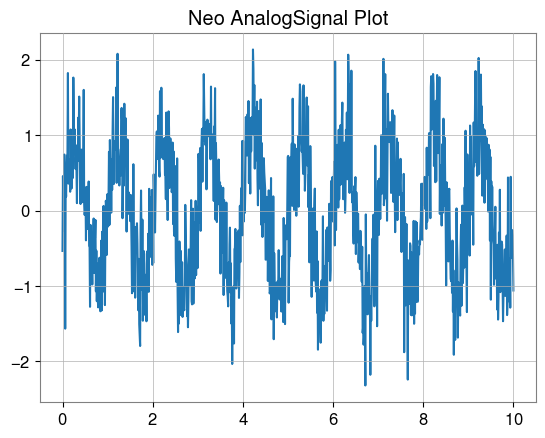

Recovered from Neo: SeriesMatrix(shape=(1, 1, 1000),  name='')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 0.01001001001001001 s
  xunit   : s
  samples : 1000

[ Row metadata ]
     name channel unit
key                   
row0                  

[ Column metadata ]
     name channel unit
key                   
col0                  

[ Elements metadata ]
  unit    name channel  row  col
0       signal    None    0    0


In [29]:
try:
    import neo

    # TimeSeries -> Neo AnalogSignal
    # to_neo is available in gwexpy.interop
    # Note: TimeseriesMatrix is preferred for multi-channel Neo conversion,
    # but we can convert single TimeSeries by wrapping it.
    from gwexpy.interop import from_neo, to_neo

    # For single TimeSeries, we might need a Matrix wrapper or direct helper.
    # Assuming helper exists or using Matrix:
    from gwexpy.timeseries import TimeSeriesMatrix

    tm = TimeSeriesMatrix(
        ts.value[None, None, :], t0=ts.t0, dt=ts.dt, channel_names=[ts.name]
    )
    sig = tm.to_neo()

    print("--- Neo AnalogSignal ---")
    print(sig)

    # Display/Plot
    plt.figure()
    plt.plot(sig.times, sig)
    plt.title("Neo AnalogSignal Plot")
    plt.show()

    # Recover
    tm_recovered = TimeSeriesMatrix.from_neo(sig)
    ts_recovered = tm_recovered[0]
    print("Recovered from Neo:", ts_recovered)

    del tm, tm_recovered, sig, ts_recovered

except ImportError:
    print("neo not installed.")

## 9. まとめ

`gwexpy` は多種多様な bilimti 向けライブラリとの相互運用を提供し、既存のエコシステムとのシームレスな統合を可能にします。
